In [1]:
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [3]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None
                                           ), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [4]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[
    gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell Tidy Data

In [5]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [7]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.linkage.csv',
    header=0,
    index_col=0)
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)

gene_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/NodeGeneResults.msg'
)
gene_assignment = gene_assignment.loc[:,
                                      gene_assignment.columns.isin(keep_gene
                                                                   )].copy()
gene_assignment.columns = gene_assignment.columns.map(gene_meta['gene_name'])

In [8]:
gene_assignment = gene_assignment[gene_assignment.index < 142].copy()
gene_assignment.tail()

,Ptprk,Camk2g,Sardh,Mgat4c,Cpm,Tiam2,Plau,Vav2,Reep3,Grb10,...,AC157784.1,AC131065.4,CT009536.1,AC132307.2,AC152452.1,AC171003.1,AC163685.1,AC125126.1,AL929073.1,Gpr52
137,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
138,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.038961,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
139,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
140,0.0,0.0,0.0,0.0,0.0,0.342593,0.0,0.0,0.0,0.018519,...,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.092593,0.0,0.027778
141,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [9]:
tf_gene_assignment = gene_assignment.loc[:,
                                         gene_assignment.columns.
                                         isin(tf_gene_names)]
other_gene_assignment = gene_assignment.loc[:, ~gene_assignment.columns.
                                            isin(tf_gene_names)]

## Normalize linkage height to 0-1

In [10]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [11]:
rs_abs_min = 0.3

records = tf_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data
tf_sum_rs = total_rs_data

(97, 5)


In [12]:
records = other_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

other_total_data = use_data
other_sum_rs = total_rs_data

(529, 5)


In [13]:
from adjustText import adjust_text

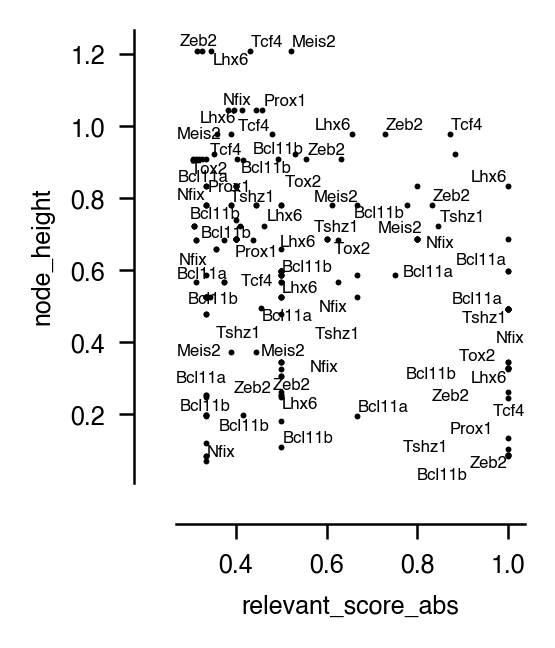

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 2), dpi=300)

sns.scatterplot(data=use_data,
                ax=ax,
                s=2,
                color='k',
                linewidth=0,
                x='relevant_score_abs',
                y='node_height')

texts = []
plot_names = use_data['gene'].value_counts()[:10].index
for _, row in use_data.iterrows():
    if row['gene'] not in plot_names:
        continue
    t = ax.text(row['relevant_score_abs'],
                row['node_height'],
                row['gene'],
                ha='center',
                va='center',
                fontsize=4)
    texts.append(t)

adjust_text(texts)

sns.despine(ax=ax, offset=10)

## TF genes

In [14]:
(tf_sum_rs / len(node_dict)).sort_values(ascending=False)[:12]

gene
Etv6      0.018911
Meis2     0.014850
Mkx       0.010833
Satb1     0.010536
Tshz3     0.009294
Trps1     0.009210
Rora      0.008426
Zbtb16    0.008410
Zic4      0.008255
Smad1     0.007637
Cux1      0.006702
Nfib      0.005727
Name: impact, dtype: float64

In [15]:
tf_sum_rs[tf_sum_rs > 0.05]

gene
Sox6      0.061292
Runx2     0.069950
Nr4a3     0.076656
Bcl11b    0.096343
Hivep1    0.102208
Zeb2      0.103153
Zfp462    0.103153
Nfix      0.123222
Grhl1     0.140819
Emx1      0.145361
Adam19    0.154730
Lhx2      0.237433
Rorb      0.245074
Zfpm2     0.257883
Nfia      0.268690
Bcl11a    0.273391
Tox       0.297156
Zfp608    0.303353
Nr3c1     0.329000
Barx2     0.375679
Jdp2      0.404444
Nfib      0.412330
Cux1      0.482556
Smad1     0.549861
Zic4      0.594384
Zbtb16    0.605487
Rora      0.606697
Trps1     0.663119
Tshz3     0.669174
Satb1     0.758581
Mkx       0.779989
Meis2     1.069232
Etv6      1.361617
Name: impact, dtype: float64

In [35]:
tf_sum_rs.sort_values(ascending=False)[:]

gene
Etv6      1.361617
Meis2     1.069232
Mkx       0.779989
Satb1     0.758581
Tshz3     0.669174
Trps1     0.663119
Rora      0.606697
Zbtb16    0.605487
Zic4      0.594384
Smad1     0.549861
Cux1      0.482556
Nfib      0.412330
Jdp2      0.404444
Barx2     0.375679
Nr3c1     0.329000
Zfp608    0.303353
Tox       0.297156
Bcl11a    0.273391
Nfia      0.268690
Zfpm2     0.257883
Rorb      0.245074
Lhx2      0.237433
Adam19    0.154730
Emx1      0.145361
Grhl1     0.140819
Nfix      0.123222
Zfp462    0.103153
Zeb2      0.103153
Hivep1    0.102208
Bcl11b    0.096343
Nr4a3     0.076656
Runx2     0.069950
Sox6      0.061292
Name: impact, dtype: float64

In [38]:
for i in tf_sum_rs.sort_values(ascending=False)[2::3].index:
    print(i)

Mkx
Trps1
Zic4
Nfib
Nr3c1
Bcl11a
Rorb
Emx1
Zfp462
Bcl11b
Sox6


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


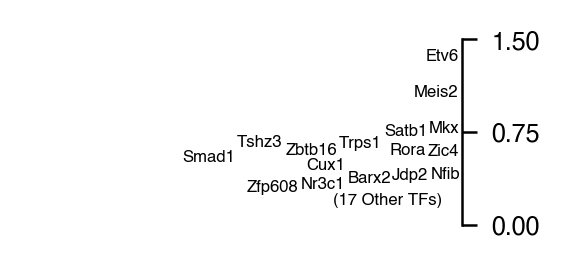

In [18]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 0.3

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.75, 1.5])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Region.TF.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

In [27]:
tf_sum_rs

gene
Sox6      0.061292
Runx2     0.069950
Nr4a3     0.076656
Bcl11b    0.096343
Hivep1    0.102208
Zeb2      0.103153
Zfp462    0.103153
Nfix      0.123222
Grhl1     0.140819
Emx1      0.145361
Adam19    0.154730
Lhx2      0.237433
Rorb      0.245074
Zfpm2     0.257883
Nfia      0.268690
Bcl11a    0.273391
Tox       0.297156
Zfp608    0.303353
Nr3c1     0.329000
Barx2     0.375679
Jdp2      0.404444
Nfib      0.412330
Cux1      0.482556
Smad1     0.549861
Zic4      0.594384
Zbtb16    0.605487
Rora      0.606697
Trps1     0.663119
Tshz3     0.669174
Satb1     0.758581
Mkx       0.779989
Meis2     1.069232
Etv6      1.361617
Name: impact, dtype: float64

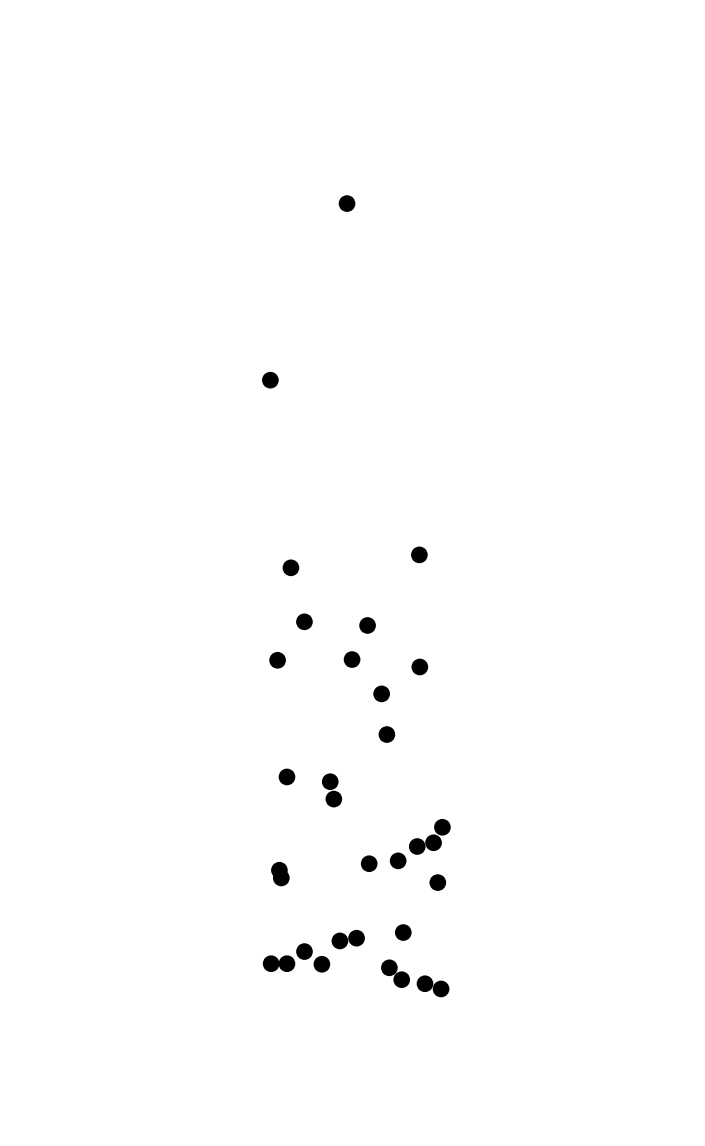

In [26]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=1200)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
ax.set(ylim=(0, 1.5))
ax.axis('off')

fig.savefig('Region.TF.total_rs.strip_plot.scatter_part.png')

## Other genes

In [20]:
other_sum_rs.describe()

count    292.000000
mean       0.217556
std        0.200592
min        0.026491
25%        0.101227
50%        0.157704
75%        0.251432
max        1.372321
Name: impact, dtype: float64

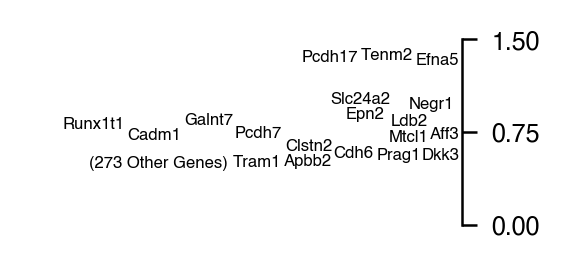

In [21]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 0.5

df = other_sum_rs[other_sum_rs > label_y_cutoff]
other_count = other_sum_rs[other_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other Genes)'] = 0.5

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 1.5)

ax.set_yticks([0, 0.75, 1.5])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Region.Other.total_rs.strip_plot.label_part.pdf', bbox_inches='tight')

In [22]:
other_sum_rs.max()

1.3723210604754779

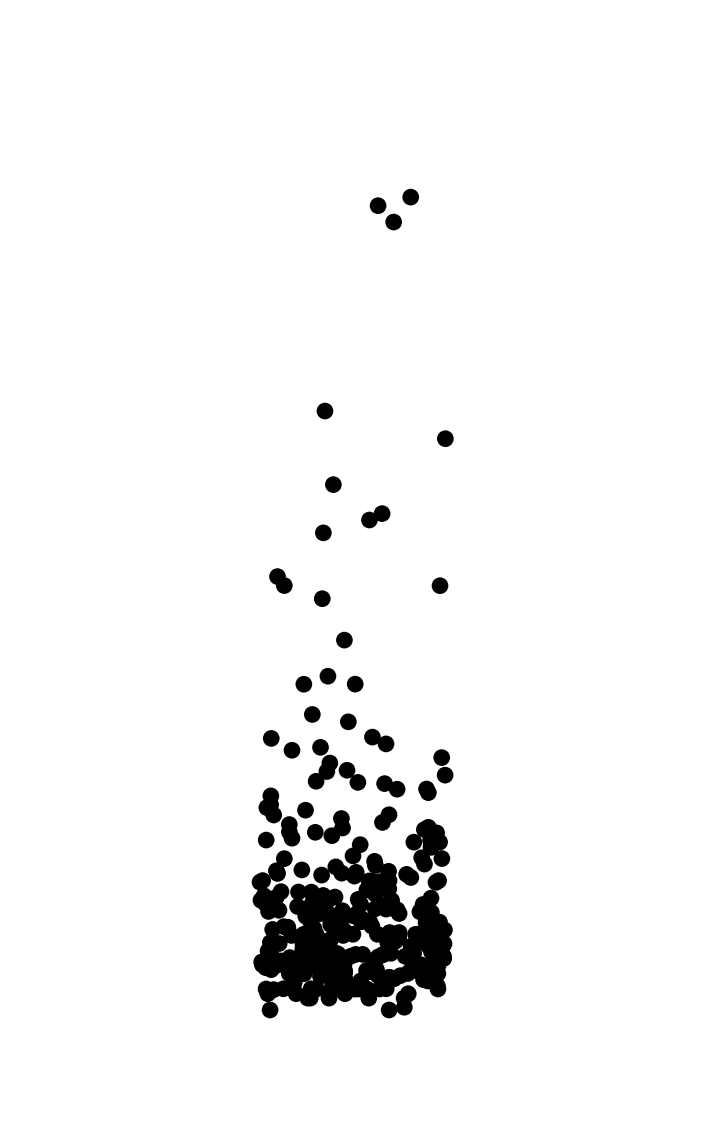

In [25]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=1200)

sns.stripplot(y=other_sum_rs, jitter=0.2, s=1, color='k', clip_on=False)
ax.set_ylim(0, 1.5)
ax.set_xticks([])
ax.axis('off')

fig.savefig('Region.Other.total_rs.strip_plot.scatter_part.png')

In [24]:
tf_sum_rs.to_csv('Region.TF.sum_rs.csv', header=False)
other_sum_rs.to_csv('Region.Other.sum_rs.csv', header=False)